# Mercado Inmobiliario - Proyecto 2
  
## Consigna
  
En este proyecto profundizarás lo desarrollado en el proyecto 01 (“Primer modelo de Machine Learning”). El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

## Parte A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

*Detección y eliminación de Outliers:* El dataset cuenta con outliers dado al EDA del proyecto 1, se implementaran varias tecnicas de deteccion y se elegira el mejor.

*Encoding*: Se crearán variables dummy para Zonas y Tipos de propiedad, ya que éstas son categóricas nominales.

*Imputación de valores faltantes*: Se analizarán los valores faltantes de Baños, Superficie Total y Cubierta, y se imputarán.

*Escalado de datos*: En algunos análisis será necesario realizar esta técnica, entre ellas, análisis de cluster y detección de Outliers.

Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA): Se entrenarán los modelos con variables reducidas.

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

### Importando librerias

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, IterativeImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest, BaggingRegressor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
sns.set()

### Lectura del dataset

In [183]:
original_data = pd.read_csv('../DS_Proyecto_01_Datos_Properati.csv')

In [184]:
data = original_data.copy()
data.head(3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


In [185]:
data.drop(columns=['lat', 'lon', 'l1', 'end_date','start_date', 'created_on', 'currency', 'title',
                   'description', 'operation_type'], inplace=True)
data.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


### Filtros

Filtrando columna *property_type* para los tipos de propiedad con una cantidad superior a 1000.

In [186]:
data['property_type'].value_counts()

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64

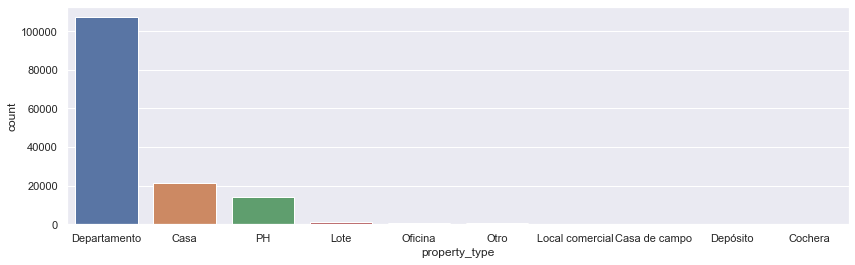

In [187]:
plt.figure(figsize=(14,4))
sns.countplot(data['property_type'], order=data['property_type'].value_counts().index)

In [188]:
counts = data['property_type'].value_counts().head(3)
properties = data['property_type'].isin(counts.index)
data = data[properties]
print('Shape:', data.shape)

Shape: (143145, 9)


### Exploración de Valores Faltantes

In [189]:
data.isna().sum()

l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4211
surface_total      18623
surface_covered    18909
price                  0
property_type          0
dtype: int64

In [190]:
def heatmap_nan_values(data, title='Valores Faltantes por columna'):
    # Plot Valores faltantes por columna
    plt.title(title, fontsize=18, pad=40)
    ax = sns.heatmap(data.isna(), cbar=False, fmt='d')
    width = ax.get_xlim()[1]/data.columns.size
    nan_values = data.isna().sum()
    for i, _ in enumerate(data.columns):
        ax.axvline(width+i, c='white')

Antes:


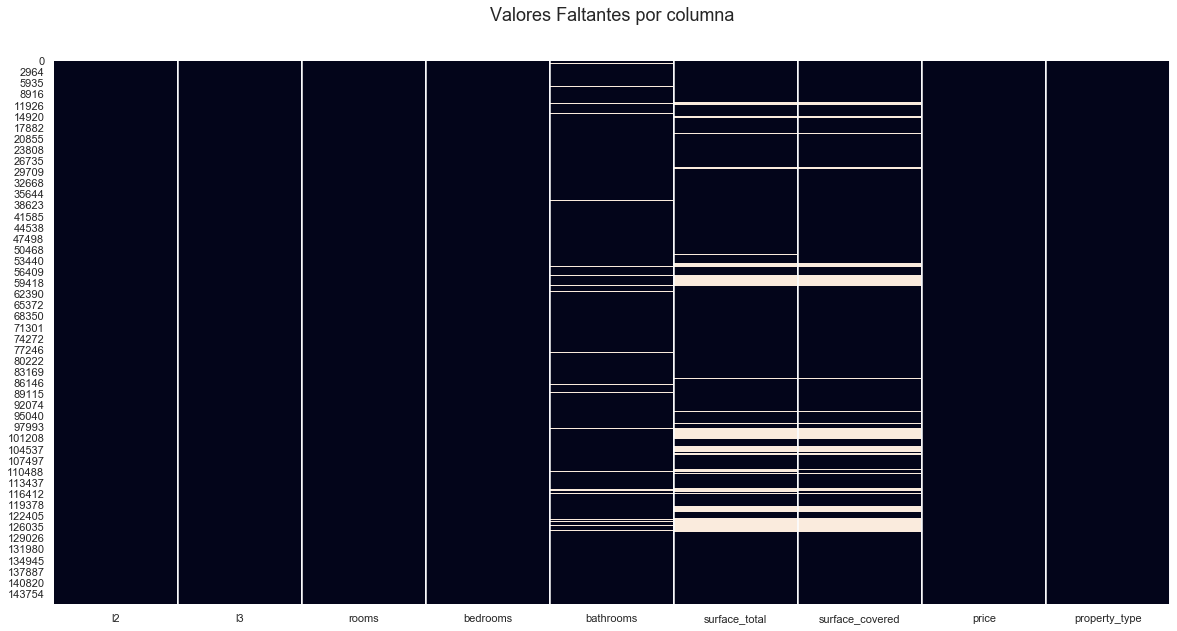

In [191]:
print('Antes:')
plt.figure(figsize=(20,10))  
heatmap_nan_values(data)

#### Bathrooms

Valores faltantes por intervalos:

In [192]:
def plot_bin_freq_nan(data, col_inter, col_target, bins=30):
    data2 = data.copy()
    col_inter = col_inter

    data2['intervals'] = pd.cut(data[col_inter], bins=bins)
    inter = data2[col_target].isna().groupby(
        data2.intervals).sum().astype(int).reset_index(name='count')
    inter['freq'] = inter['count'] / \
        data2[col_target].groupby([data2.intervals]).count().values
    inter['mid'] = inter.intervals.apply(lambda x: x.mid)
    # Plot
    plt.title(f'{col_target} / {col_inter}', fontdict={'fontsize': 14})
    plt.scatter(inter.mid, inter.freq)
    plt.xlabel('Intervalos: '+col_inter)
    plt.ylabel('Frecuencias NaN')

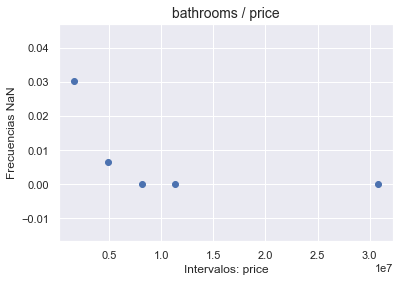

In [193]:
plot_bin_freq_nan(data, 'price','bathrooms',10)

La variable baños es __MNAR__ con respecto al precio. Se aprecia una relacion decreciente y proporcional.

Como se trata de una variable continua discreta y tipo entero, se rellenarán sus valores faltantes de acuerdo a la moda de ésta variable, teniendo en cuenta las zonas y el tipo de propiedad:

* Agregando indicador de dato faltante usando sklearn:

In [194]:
indicator_bathrooms = MissingIndicator().fit_transform(data[['bathrooms']])
data['missing_bathrooms'] = indicator_bathrooms.astype(int)
data.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,missing_bathrooms
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,0
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,0
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,0
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,0
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH,0


* Distribución porcentual de Valores faltantes por zona y tipo de propiedad:

In [195]:
def barplot_missing_values(data, col):
    # Dataframe nuevo con valores faltantes
    data_na = (data.isna()[col].groupby(
        [data.l2, data.property_type]).sum()/data[col].groupby(
        [data.l2, data.property_type]).count()).to_frame().reset_index()
    data_na.sort_values(by=[col], ascending=False, inplace=True)

    # Grafica
    plt.title(f'Valores Faltantes: {col}', fontdict={'fontsize': 15}, pad=20)
    sns.barplot(data=data_na, x='property_type', y=col, hue='l2', palette='PuBu_r')
    plt.ylabel('Valores faltantes', fontdict={'fontsize': 13}, labelpad=20)
    plt.xlabel('Tipo de propiedad', fontdict={'fontsize': 13}, labelpad=20)

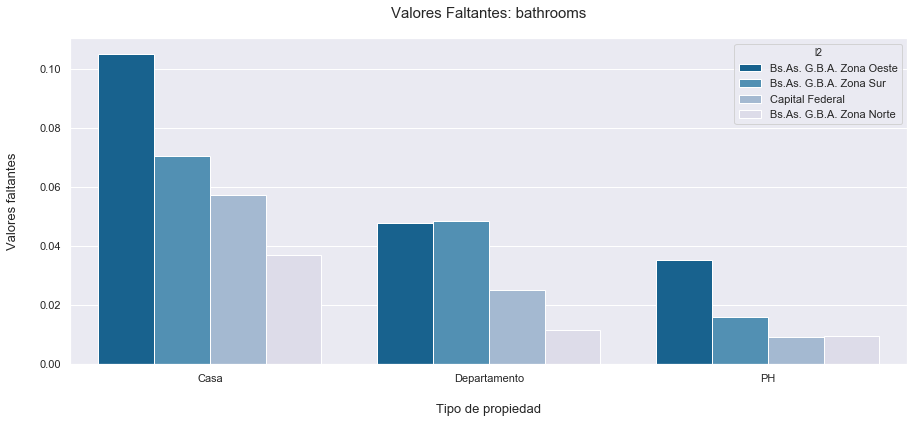

In [196]:
plt.figure(figsize=(15, 6))
barplot_missing_values(data, 'bathrooms')

* Valor más frecuente sin valores faltantes con segmentación por zona y tipo de propiedad:

In [197]:
def get_pivot_table():
    return data.pivot_table(index='l2', columns='property_type', aggfunc=lambda x: x.groupby(
        by=[data['property_type'], data['l2']]).agg(lambda y: y.value_counts().index[0]))['bathrooms']

In [198]:
get_pivot_table()

property_type,Casa,Departamento,PH
l2,,,
Bs.As. G.B.A. Zona Norte,2.0,1.0,1.0
Bs.As. G.B.A. Zona Oeste,1.0,1.0,1.0
Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0
Capital Federal,2.0,1.0,1.0


* Aplicando el método para llenar valores faltantes:  
Se llenaran los valores faltantes con la Moda especializando por tipo de propiedad y zona, y no de toda la columna.

In [199]:
data['bathrooms'].fillna(data['bathrooms'].groupby(
    [data.property_type, data.l2]).transform(lambda x: x.value_counts().index[0]), inplace=True)

In [200]:
get_pivot_table()

property_type,Casa,Departamento,PH
l2,,,
Bs.As. G.B.A. Zona Norte,2.0,1.0,1.0
Bs.As. G.B.A. Zona Oeste,1.0,1.0,1.0
Bs.As. G.B.A. Zona Sur,2.0,1.0,1.0
Capital Federal,2.0,1.0,1.0


Despues:


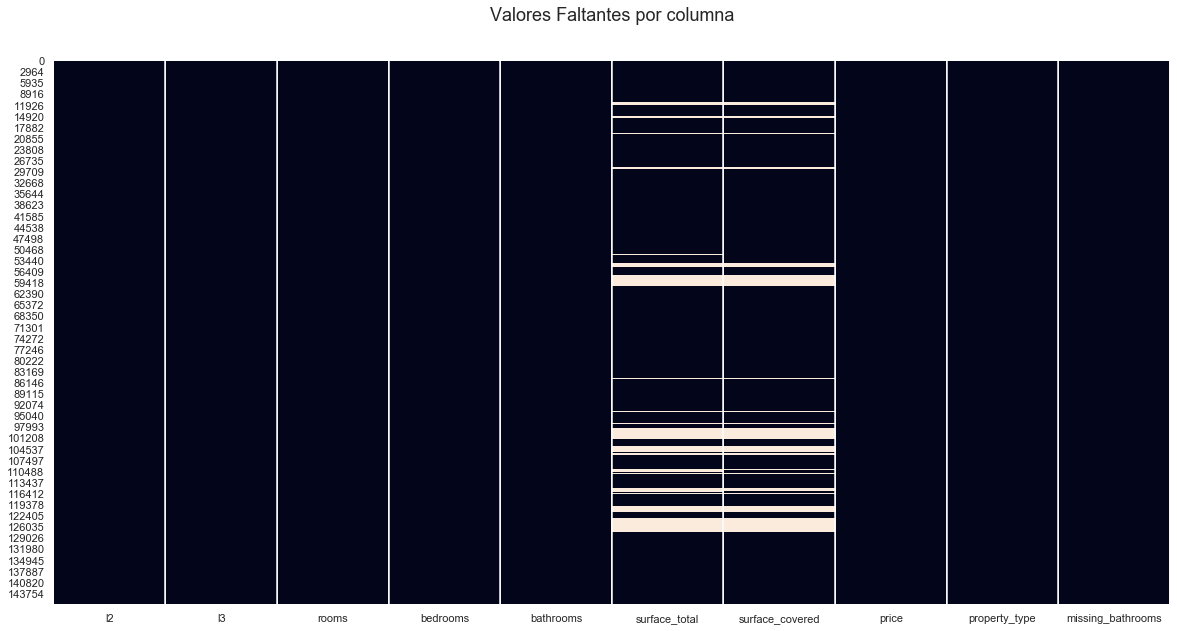

In [201]:
print('Despues:')
plt.figure(figsize=(20,10))
heatmap_nan_values(data)

#### SurfaceTotal / Covered

* Valores faltantes por intervalos:

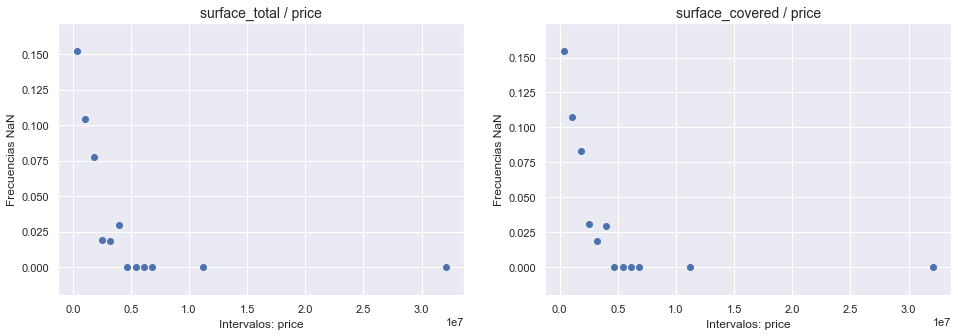

In [202]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_bin_freq_nan(data, 'price', 'surface_total', 45)
plt.subplot(1, 2, 2)
plot_bin_freq_nan(data, 'price', 'surface_covered', 45)

La variable Superficie Total y Cubierta tambien son MNAR con respecto al precio. Se aprecia una relacion decreciente y proporcional.

* Heatmap de valores faltantes

In [203]:
plt.figure(figsize=(20, 10))

def heatmaps_by_column(data, col):
    categories = set(data[col])
    for i, category in enumerate(categories, start=1):
        df = data.query(f'{col}==@category')
        plt.subplot(1, len(categories), i)
        plt.title(category)
        heatmap_nan_values(df[['surface_covered', 'surface_total']], category)

<Figure size 1440x720 with 0 Axes>

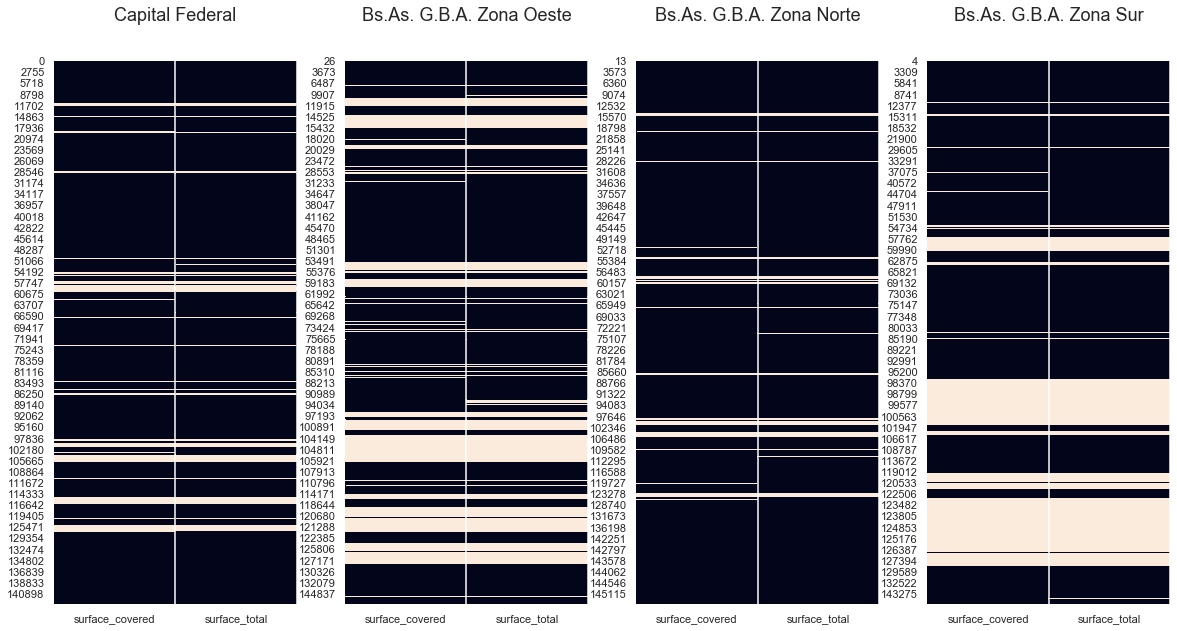

In [204]:
plt.figure(figsize=(20,10))
heatmaps_by_column(data, 'l2')

En Zona Sur se nota una gran franja de valores faltante, quizás se debe a zonas marginadas de las cuales no se tiene mucho registro.

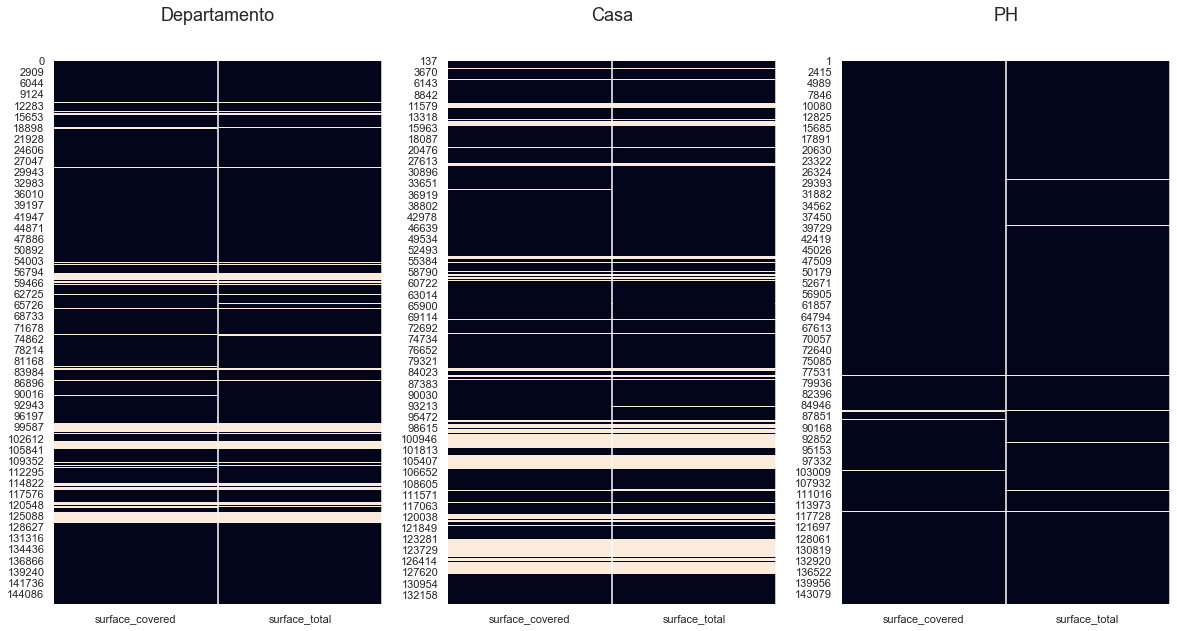

In [205]:
plt.figure(figsize=(20,10))
heatmaps_by_column(data, 'property_type')

* Distribución porcentual de Valores faltantes por zona y tipo de propiedad para Superficie Total y Cubierta:

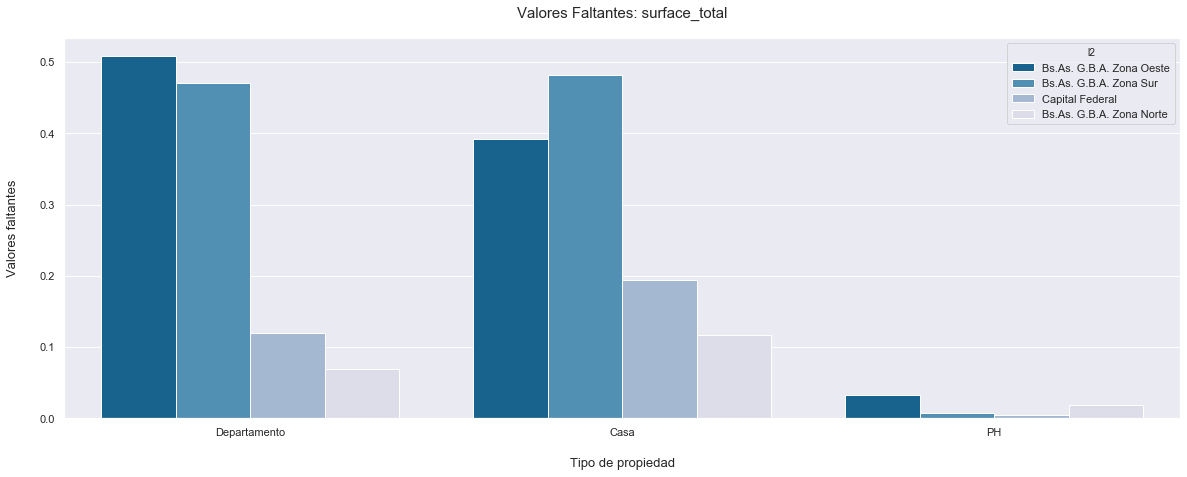

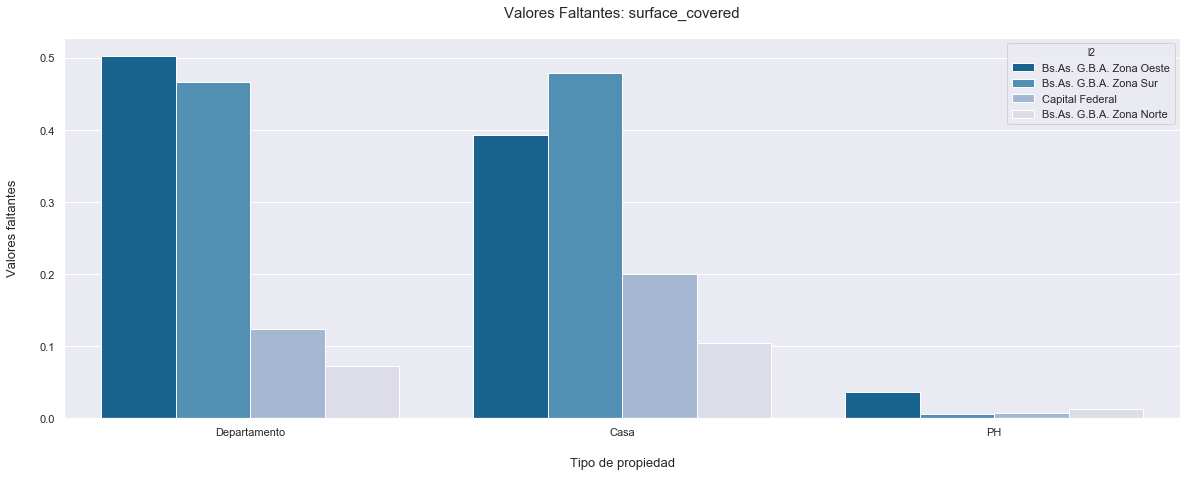

In [206]:
plt.figure(figsize=(20, 7))
barplot_missing_values(data, 'surface_total')
plt.show()

plt.figure(figsize=(20, 7))
barplot_missing_values(data, 'surface_covered')
plt.show()

### Encoding

* Creando variables dummy para *l2* y *property_type*

In [207]:
bin_propertyType = LabelBinarizer()
bin_l2 = LabelBinarizer()

In [208]:
dummy_propertyType = bin_propertyType.fit_transform(
    data[['property_type']])
dummy_l2 = bin_l2.fit_transform(data[['l2']])

In [209]:
dummy_l2_names = ['l2_'+'_'.join(col.split()[-2::]) for col in bin_l2.classes_]
dummy_propertyType_names = ['prop_'+col for col in bin_propertyType.classes_]

* Dataframe de dummies

In [210]:
df_dummies = pd.DataFrame(
    np.c_[dummy_l2, dummy_propertyType], columns=dummy_l2_names+dummy_propertyType_names)

In [211]:
df_dummies

,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH
0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1
4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
143140,0,0,1,0,0,1,0
143141,1,0,0,0,0,1,0
143142,1,0,0,0,0,1,0
143143,1,0,0,0,0,1,0


In [212]:
data_with_dummies = pd.merge(
    data, df_dummies, on=data.index).drop('key_0', axis=1)

In [213]:
#Barrios (columna l3) para trabajar el Desafio
l3 = data_with_dummies['l3']

In [214]:
data_with_dummies.drop(data_with_dummies.select_dtypes(
    'object').columns, axis=1, inplace=True)

In [215]:
data_with_dummies.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,missing_bathrooms,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,0,1,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,1,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,1,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,1,0,0,1
4,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,1,0,0,0,1


No se realizó el procedimiento para la columna l3 (Barrios) ya que ésta posee demasiadas categorias (>50) que al crear el dummy se obtendría un dataset saturado de dimensiones.

### Imputación de valores faltantes

Se utilizarán dos métodos para imputar las superficies total y cubierta, el primero mediante sklearn pasando un estimador como parámetro, después se imputará a través de un modelo e iterando por las columnas con valores faltantes (a mano). Se compararan ambos metodos y se elegira el mejor.

Copia del dataframe:

In [216]:
data_method1 = data_with_dummies.copy()

#### Con Sklearn

In [217]:
iterative_imputer = IterativeImputer(
    DecisionTreeRegressor(), add_indicator=True, random_state=0)
iterative_imputer.fit(data_method1)

C:\Users\Erick\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=True,
                 estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                                 max_depth=None,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 splitter='best'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max

In [218]:
data_method1 = pd.DataFrame(iterative_imputer.transform(
    data_method1), columns=np.append(data_method1.columns, ['missing_surface_total', 'missing_surface_covered']))

In [219]:
data_method1.isna().sum()

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_total      0
missing_surface_covered    0
dtype: int64

* Mapa de dispersion de Valores Faltantes vs No Faltante

In [220]:
def scatterplot_surfaces_price(data):
    sns.set()
    plt.figure(figsize=(20, 14))
    fontdict = {'fontsize': 20}

    for i, col in enumerate(['surface_total', 'surface_covered']):
        # Mascara
        ismissing = (data['missing_'+col] == 1)

        # Plot
        plt.subplot(2, 1, i+1)
        sns.scatterplot(data[col],
                        data.price,
                        hue=data['missing_' + col],
                        style=data['missing_'+col],
                        palette=['#DB4437', 'black'],
                        size=data['missing_'+col],
                        sizes=(200, 200), alpha=.5)

        plt.title('Dispersión: Valores Faltantes/No Faltantes',
                  fontdict=fontdict)
        plt.legend(fontsize='x-large')
        plt.xlabel(col, fontdict=fontdict, labelpad=15)
        plt.ylabel('Precio', fontdict=fontdict, labelpad=15)
        plt.tight_layout(pad=3.0)

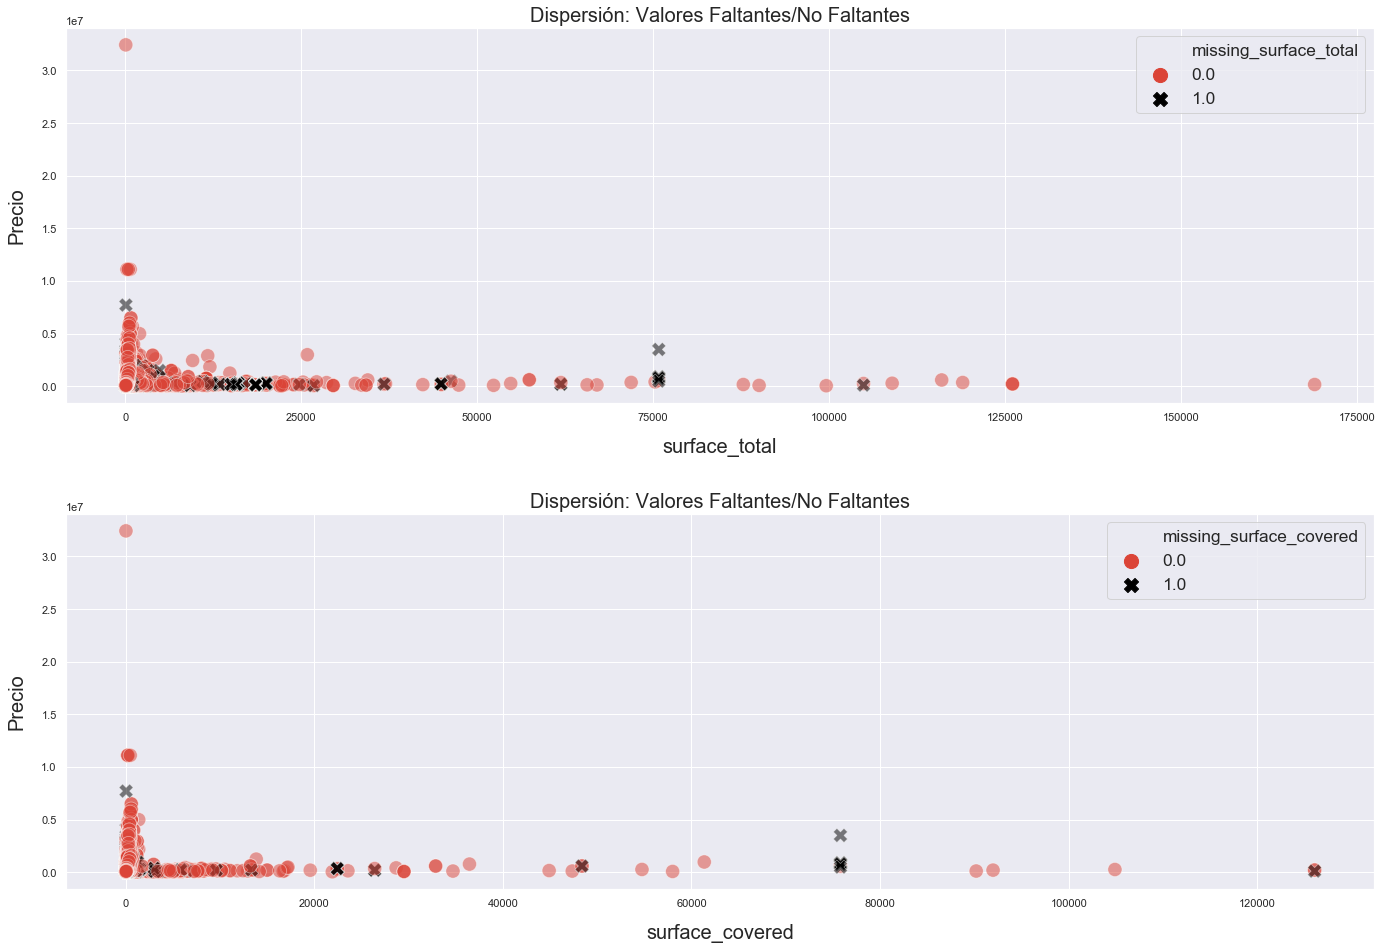

In [221]:
scatterplot_surfaces_price(data_method1)

#### Procedimiento manual

Se creará un algoritmo que itere sobre las columnas faltantes eligiendo como datos de entrenamientos los No Faltantes de todas las columnas con excepción de la columna objetivo, esta columna será definida como el target de entrenamiento.

In [222]:
data_method2 = data_with_dummies.copy()

* Indicador de dato faltante:

In [223]:
# Surface covered
missingInd_surf_covered = MissingIndicator().fit_transform(
    data_method2[['surface_covered']])

# surface_total
missingInd_surf_total = MissingIndicator().fit_transform(
    data_method2[['surface_total']])

In [224]:
data_method2['missing_surface_covered'] = missingInd_surf_covered.astype(int)
data_method2['missing_surface_total'] = missingInd_surf_total.astype(int)

In [225]:
while data_method2.isna().sum().any():
    cols_with_nan = data_method2.columns[data_method2.isna().any()]
    cols_no_nan = data_method2.columns.difference(cols_with_nan)
    #Se elige la primera columna con valores faltantes, el orden es imprescindible
    col_nan = cols_with_nan[0]
    df_m2 = data_method2[np.append(cols_no_nan, col_nan)]
    X_train_m2 = df_m2.dropna()[cols_no_nan]
    y_train_m2 = df_m2.dropna()[col_nan]
    #Para los datos de validacion se seleccionan aquellos registros 
    #                           en donde la columna objetivo presenta valores faltantes.
    X_test_m2 = df_m2[df_m2[col_nan].isna()][cols_no_nan]
    #Entrenando el modelo
    model_imputer = DecisionTreeRegressor(
        random_state=0).fit(X_train_m2, y_train_m2)
    y_imputed = model_imputer.predict(X_test_m2)
    data_method2.loc[data_method2[col_nan].isna(), col_nan] = y_imputed

In [226]:
data_method2.isna().sum()

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_covered    0
missing_surface_total      0
dtype: int64

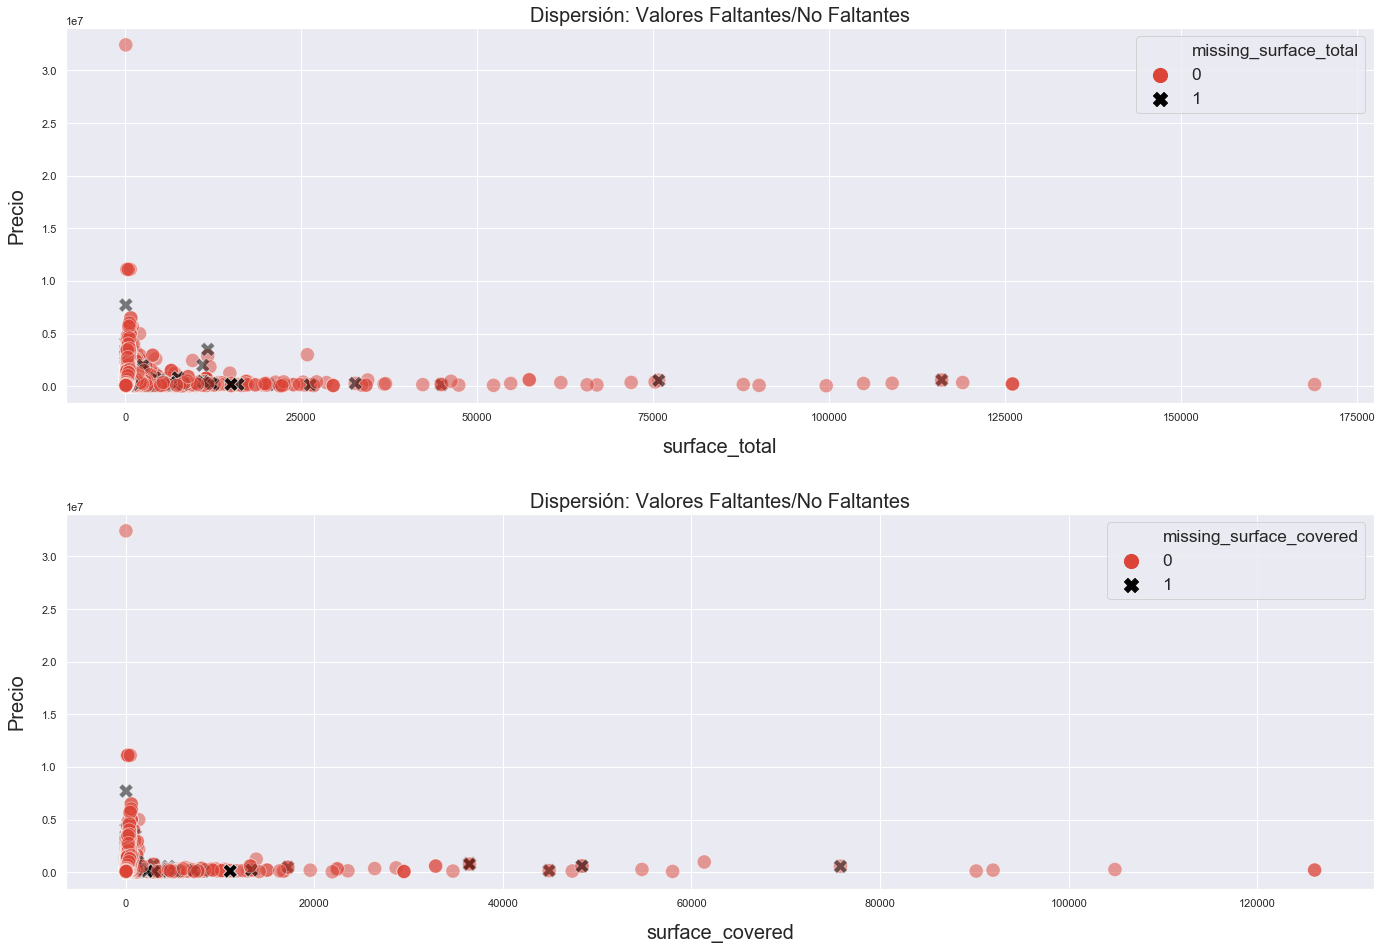

In [227]:
scatterplot_surfaces_price(data_method2)

* Asignando el dataframe sin valores faltantes mediante Sklearn, ya que usa un método optimizado para imputar estos valores; con el algoritmo elaborado manuamente es posible que se esten omitiendo casos sin considerar causando pérdida de información.

In [228]:
data = data_method1

Dataframe para el desafio, hasta este punto el dataframe no tiene valores faltantes, tiene variables dummy, ahora solo se concatena la columna barrios

In [229]:
data_challenge=pd.concat([data, l3], axis=1)

In [230]:
data.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,missing_bathrooms,l2_Zona_Norte,l2_Zona_Oeste,l2_Zona_Sur,l2_Capital_Federal,prop_Casa,prop_Departamento,prop_PH,missing_surface_total,missing_surface_covered
0,7.0,7.0,2.0,140.0,140.0,153000.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1.0,1.0,50.0,35.0,40000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [231]:
print(data.isna().sum())

rooms                      0
bedrooms                   0
bathrooms                  0
surface_total              0
surface_covered            0
price                      0
missing_bathrooms          0
l2_Zona_Norte              0
l2_Zona_Oeste              0
l2_Zona_Sur                0
l2_Capital_Federal         0
prop_Casa                  0
prop_Departamento          0
prop_PH                    0
missing_surface_total      0
missing_surface_covered    0
dtype: int64


###  Deteccion y eliminacion de Outliers

Se eliminaran los valores outliers mediante clusterizacion con DBSCAN y el metodo IQR en las columnas *surface_total* y *price*, luego se compara el resultado obtenido de ambos metodos.

#### DBSCAN

In [232]:
data_dbscan = data.copy()

In [233]:
dbscan = DBSCAN(eps=15, min_samples=20).fit(data_dbscan)

In [234]:
print(str((dbscan.labels_ == -1).sum())+' outliers')

48537 outliers


Transformación inversa de dummy a categórica de los tipos de propiedad, para poder distinguir en las próximas gráficas:

In [235]:
def inverse_transform_prop_type(data):
    return bin_propertyType.inverse_transform(
        np.stack([data.prop_Casa, data.prop_Departamento, data.prop_PH], axis=1))

In [236]:
data_dbscan['property_type'] = inverse_transform_prop_type(data_dbscan)

Asignando etiqueta al dataframe para clasificar los outliers:

In [237]:
data_dbscan['is_outlier'] = dbscan.labels_ == -1
is_outliers_dbscan = data_dbscan['is_outlier']

Distribución de la superficie cubierta para los tipos de propiedad:

In [238]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size=20,
            ha="left", va="center", transform=ax.transAxes)

In [239]:
def distplot_property_type(data, column, hue):
    sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(data, aspect=8, row=hue, hue=hue, height=2.5,
                      palette=['#4285F4', '#DB4437', '#0F9D58'])
    g = g.map(sns.kdeplot, column, alpha=1, shade=True)

    g = g.map(plt.axhline, lw=10)
    g.map(label, column)
    g.set_titles('')
    g.fig.subplots_adjust(hspace=-.15)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    sns.set()

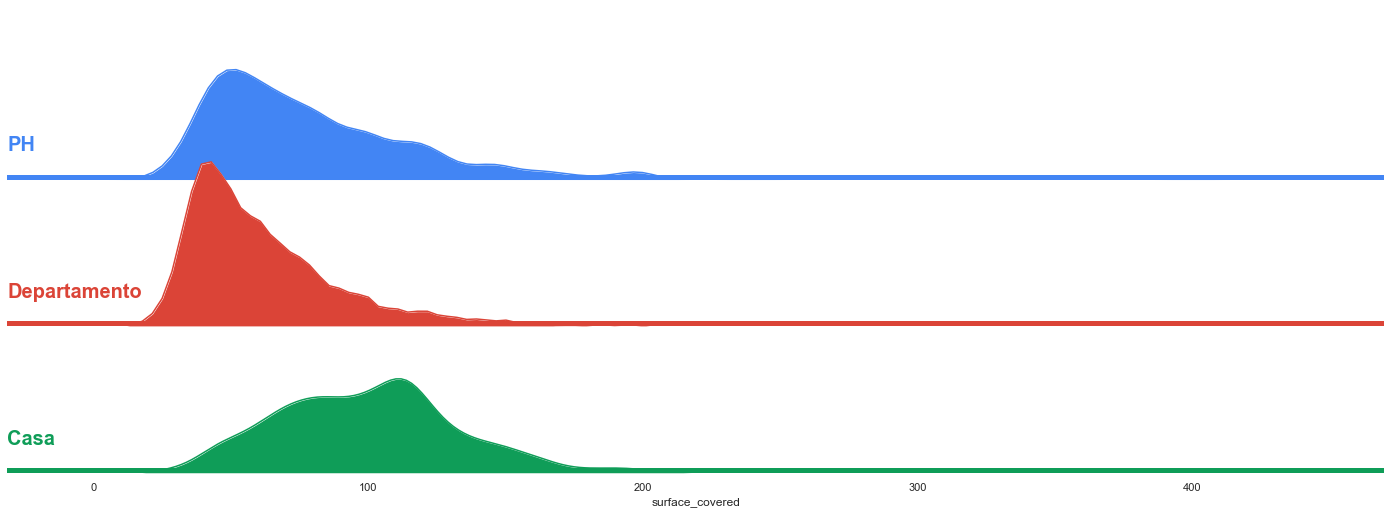

In [240]:
distplot_property_type(
    data_dbscan[~is_outliers_dbscan], 'surface_covered', 'property_type')

Examinando dispersion de datos:

In [241]:
def scatter_plot(data, title, col_x, col_y='price', hue='property_type'):
    plt.figure(figsize=(7, 5))
    plt.title(title, fontdict=dict(fontsize=15))
    s = sns.scatterplot(data[col_x],
                        data[col_y],
                        hue=data[hue],
                        palette=['#714cfe', '#09AF00', '#fa8100'],
                        alpha=.6,
                        s=70)

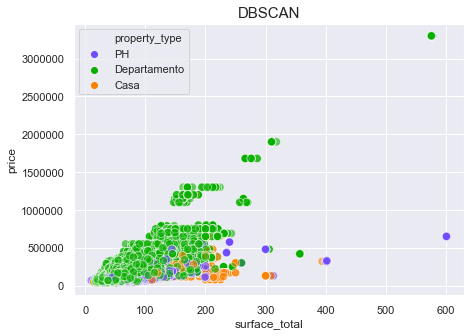

In [242]:
scatter_plot(data_dbscan[~is_outliers_dbscan], 'DBSCAN', 'surface_total')

In [243]:
#data_dbscan = data_dbscan[~is_outliers_dbscan]
data_dbscan.drop(['is_outlier', 'property_type'], axis=1, inplace=True)

#### IsolationForest

In [374]:
data_isolation = data.copy()

Creando la instancia del objeto y entrenándolo:

In [375]:
isoForest = IsolationForest(n_estimators=200,
                            contamination=.2, random_state=42).fit_predict(data_isolation)

In [376]:
print(f'{(isoForest==-1).sum()} outliers')

28628 outliers


In [377]:
data_isolation['property_type'] = inverse_transform_prop_type(data_isolation)

Asignando etiqueta al dataframe para clasificar los outliers:

In [378]:
data_isolation['is_outlier'] = isoForest == -1
is_outlier_isoforest = data_isolation['is_outlier']

Distribución de la superficie cubierta para los tipos de propiedad:

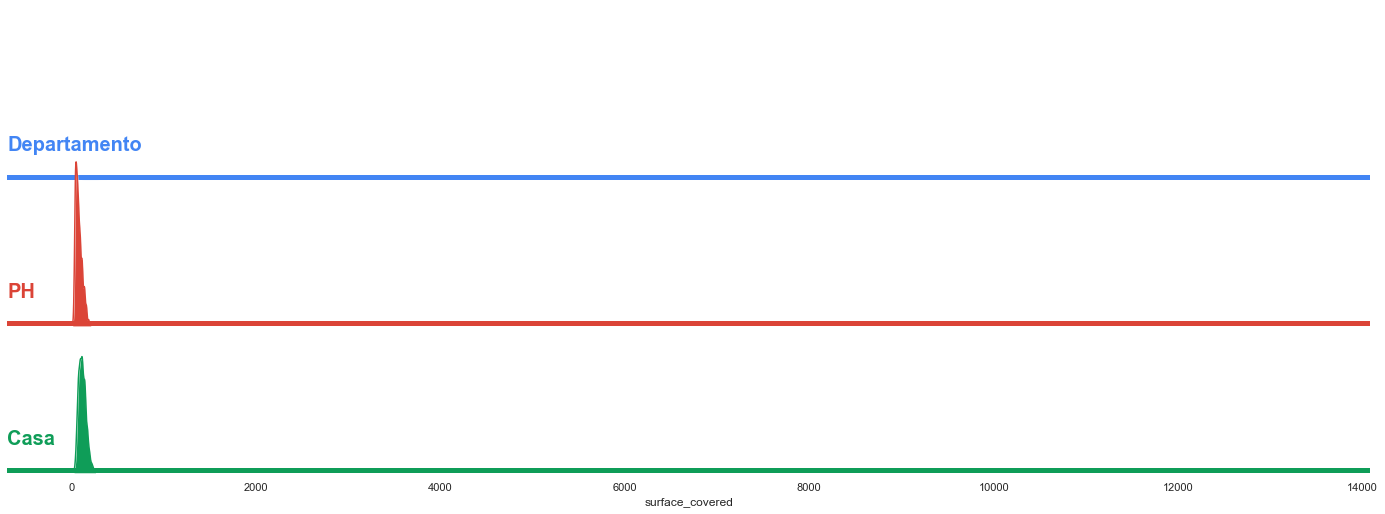

In [379]:
distplot_property_type(
    data_isolation[~is_outlier_isoforest], 'surface_covered', 'property_type')

Dispersion de datos:

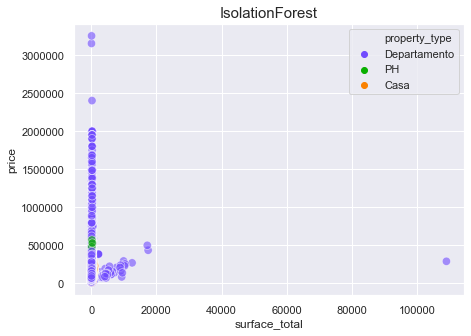

In [380]:
scatter_plot(data_isolation[~is_outlier_isoforest],
             title='IsolationForest', col_x='surface_total')

In [381]:
data_isolation = pd.concat([data_isolation, l3], axis=1)

In [382]:
data_isolation = data_isolation[~is_outlier_isoforest]
data_isolation.drop(['property_type', 'is_outlier'], inplace=True, axis=1)

#### LocalOutlierFactor

In [383]:
data_LOF = data.copy()

Escalado de datos:

In [384]:
standarScaler_LOF = RobustScaler()
data_LOF_scaled = standarScaler_LOF.fit_transform(
    data_LOF.drop('price', axis=1))
data_LOF_scaled = pd.DataFrame(
    data_LOF_scaled, columns=data_LOF.drop('price', axis=1).columns)
data_LOF_scaled = pd.concat([data_LOF_scaled, data_LOF['price']], axis=1)

Creando la instancia del objeto LocalOutlierFactor:

In [385]:
localOutlierFactor = LocalOutlierFactor(n_jobs=-1, n_neighbors=20, contamination=.2).fit_predict(data_LOF_scaled)

In [386]:
data_LOF_scaled['is_outlier'] = localOutlierFactor == -1
is_outlier_LOF = data_LOF_scaled['is_outlier']
data_LOF_scaled.is_outlier.value_counts()

False    114518
True      28627
Name: is_outlier, dtype: int64

In [387]:
data_LOF_scaled['property_type'] = inverse_transform_prop_type(
    data_LOF)

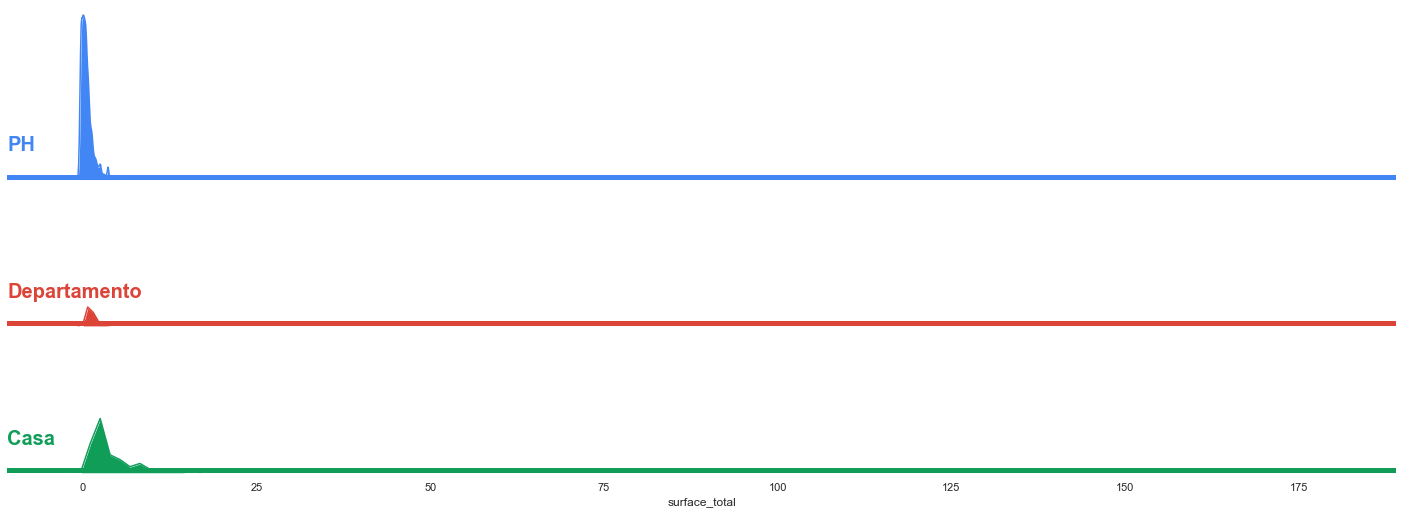

In [388]:
distplot_property_type(
    data_LOF_scaled[~is_outlier_LOF], 'surface_total', 'property_type')

Mapa de dispersion:

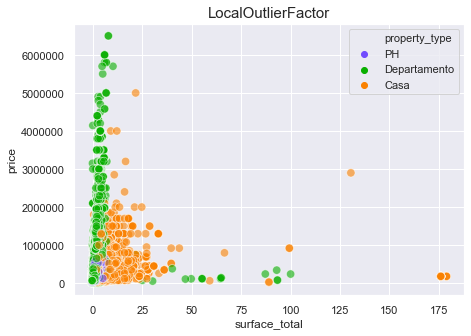

In [389]:
scatter_plot(data_LOF_scaled[~is_outlier_LOF], title='LocalOutlierFactor', col_x='surface_total')

In [390]:
data_LOF_scaled[~is_outlier_LOF].property_type.value_counts()

Departamento    83962
Casa            18528
PH              12028
Name: property_type, dtype: int64

In [391]:
data_LOF_scaled=data_LOF_scaled[~is_outlier_LOF]

In [392]:
drop_colummns = ['is_outlier', 'property_type']
data_LOF_scaled.drop(drop_colummns, axis=1, inplace=True)

#### IQR

In [393]:
data_iqr = data.copy()

In [394]:
# Funcion para remover outliers mediante metodo IQR
def remove_outliers_iqr(column, data):
    q1 = data[column].quantile(.25)
    q3 = data[column].quantile(.75)
    iqr = q3-q1
    min_iqr = q1-1.5*iqr
    max_iqr = q3+1.5*iqr
    return data.query(f'@min_iqr <= {column} <= @max_iqr')

In [395]:
data_iqr = remove_outliers_iqr('price', data_iqr)
data_iqr = remove_outliers_iqr('surface_total', data_iqr)
data_iqr = remove_outliers_iqr('surface_covered', data_iqr)

In [396]:
data_iqr['property_type'] = inverse_transform_prop_type(data_iqr)

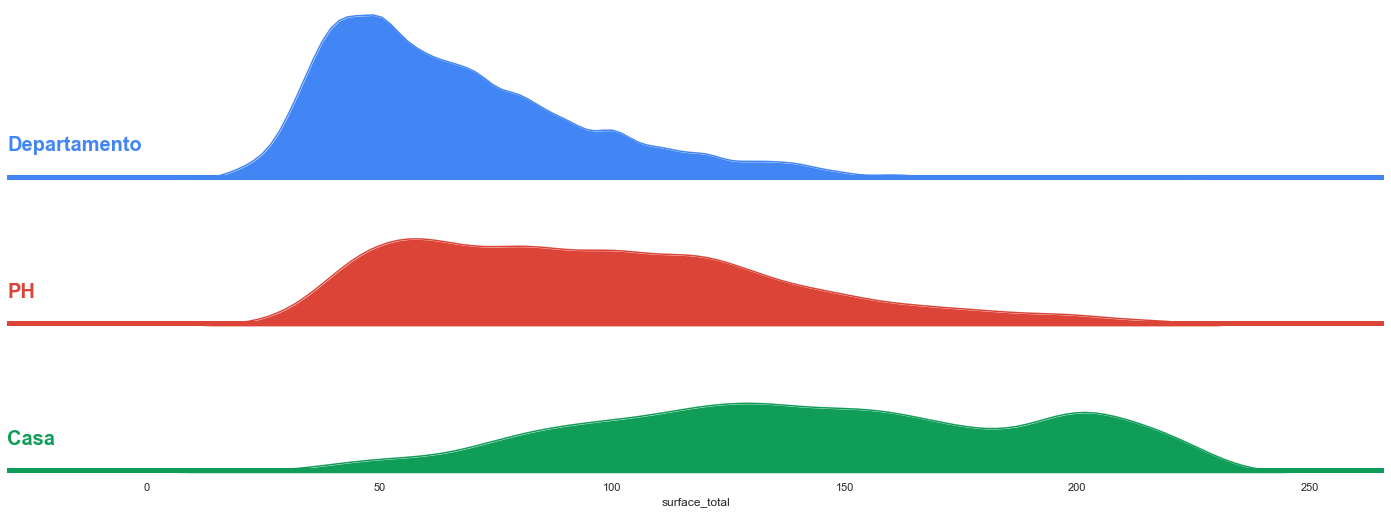

In [397]:
distplot_property_type(data_iqr, 'surface_total', 'property_type')

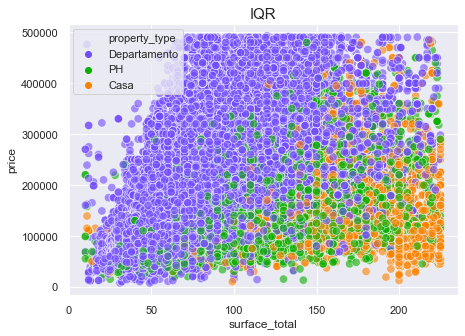

In [398]:
scatter_plot(data_iqr, title='IQR', col_x='surface_total')

In [399]:
data_iqr.drop('property_type', axis=1, inplace=True)

#### Conclusiones

Al observar la dispersion de la superficie total con respecto al precio con el metodo LocalOutputFactor se nota una clara separacion entre dos tipos de propiedad, lo cual puede beneficiar el modelo. El metodo DBSCAN parece superar a IsolationForest porque la distribucion obtenida es mas parecida a la normal, pero la dispersion de los datos no es muy clara.

El Metodo IQR parece efectivo, sin embargo se hizo el ajuste para las 3 variables. Al eliminar instancias de una variable se perderia informacion potencialmente importante.

Al realizar iteraciones con los algoritmos de Sklearn obtuve menores error con IsolationForest aplicando una contaminacion del 25%.

Se intentó con StandarScaler, MinMaxScaler, y finalmente con RobustScaler el rendimiento mejoró.

In [400]:
standard_for_cluster = StandardScaler().fit_transform(
    data_isolation.drop('l3', axis=1))
dbscan_l3 = DBSCAN(n_jobs=-1, eps=0.5, min_samples=1000).fit_predict(standard_for_cluster)

In [401]:
np.unique(dbscan_l3, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18], dtype=int64),
 array([36546,  1430, 20385,  4679,  5818,  1758,  2229, 13110,  2851,
         6747,  1444,  2847,  4928,  1246,  1872,  1691,  1017,  1067,
         1296,  1556], dtype=int64))

In [402]:
data_isolation['cluster_l3'] = dbscan_l3

In [403]:
data_isolation.query('cluster_l3!=-1', inplace=True)

In [404]:
data_isolation.drop('l3', axis=1, inplace=True)

In [405]:
data_isolation=pd.get_dummies(data_isolation, columns=['cluster_l3'], prefix='cluster')

In [406]:
data_final = data_isolation  # IsolationForest
robustScaler = RobustScaler()
scaled_data_final = robustScaler.fit_transform(
    data_final.drop('price', axis=1))

In [407]:
scaled_data_final.shape[1]

34

### PCA

Al desconocer el numero de componentes ideal, se decidio crear un ciclo hasta el numero de componentes maximo para obtener la suma de las varianzas y el valor RMSE de un modelo basico de arbol de decisión:

In [408]:
variances = []
individual_variances = []
error_test, error_train = [], []
n_components = np.arange(1, scaled_data_final.shape[1])

for i in n_components:
    pca_loop = PCA(n_components=i)
    data_pca_loop = pca_loop.fit_transform(scaled_data_final)
    variance_ratio = pca_loop.explained_variance_ratio_
    individual_variances.append(variance_ratio)
    variances.append(variance_ratio.sum())

    # Entrenamiento Modelos
    X = data_pca_loop
    y = data_final.price
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=0)
    tree = DecisionTreeRegressor(random_state=20).fit(X_train, y_train)
    y_pred_test = tree.predict(X_test)
    y_pred_train = tree.predict(X_train)
    error_test.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    error_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))

* Curva de errores en Entrenamiento y Validacion.

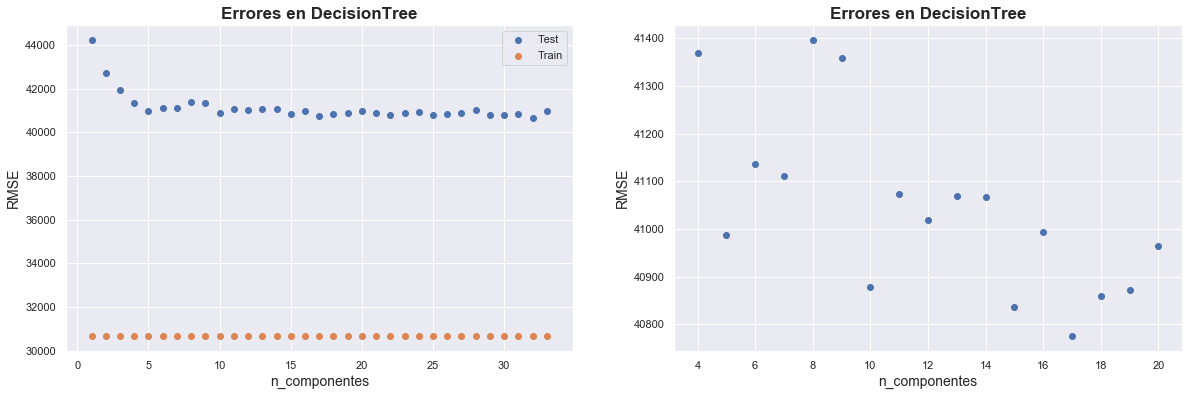

In [409]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
font_title=dict(fontsize=17, fontweight='bold')
font_axis=dict(fontsize=14)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('RMSE', fontdict=font_axis)
plt.title('Errores en DecisionTree', fontdict=font_title)
plt.scatter(n_components, error_test, label='Test')
plt.scatter(n_components, error_train, label='Train')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('RMSE', fontdict=font_axis)
plt.title('Errores en DecisionTree', fontdict=font_title)
plt.scatter(n_components[3:20], error_test[3:20], label='Test')

* Analisis Varianzas

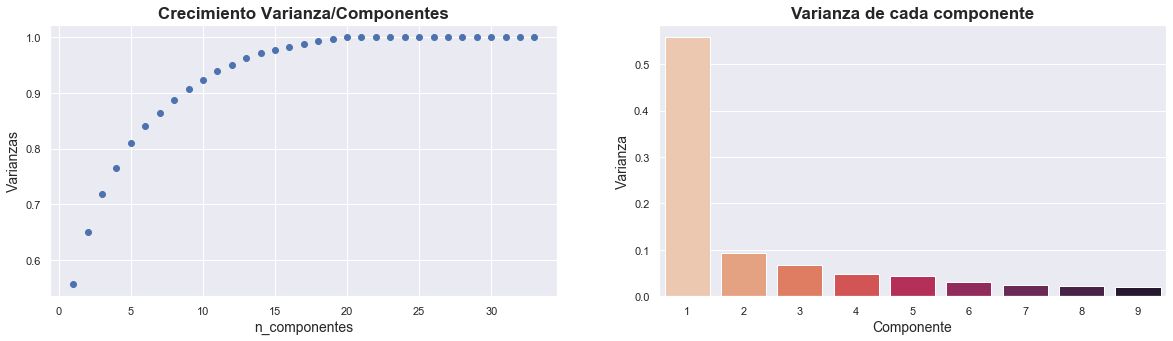

In [410]:
font_title = dict(fontsize=17, fontweight='bold')
font_axis = dict(fontsize=14)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.xlabel('n_componentes', fontdict=font_axis)
plt.ylabel('Varianzas', fontdict=font_axis)
plt.title('Crecimiento Varianza/Componentes', fontdict=font_title)
plt.plot(n_components, variances,'o')

plt.subplot(1, 2, 2)
k = 9
plt.title('Varianza de cada componente', fontdict=font_title)
plt.xlabel('Componente', fontdict=font_axis)
plt.ylabel('Varianza', fontdict=font_axis)
sns.barplot(np.arange(1, k+1), individual_variances[k-1], palette='rocket_r')

En el primer grafico, los errores en Arbol de Decision estan entre 70.000 y 80.000 dolares a partir de 4 componentes, en el segundo grafico de Crecimiento de Varianza/Componentes vemos que a partir de 2 componentes se obtienen varianzas superiores al  95%.  
  
Seleccionar 6 componentes sería una opción viable porque corresponde a una varianza cercana al 100% y segun la curva de errores corresponde al valor minimo. Tambien con 12 componentes equivale a varianza casi del 100% y con el minimo error (con una diferencia poco notable) pero por esta razon se esta aplicando la reduccion con PCA, seleccionar el menor numero de componentes posibles que expliquen los datos.

Creando PCA con 6 componentes:

In [411]:
pca = PCA(n_components=5)
data_pca = pca.fit_transform(scaled_data_final)

### Modelo Benchmark

In [412]:
X = data_pca
y = data_final.price
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42)

In [413]:
tree_model = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

Función para distribución de errores:

In [414]:
def dist_errors(model, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f'Modelo: {model_name}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.distplot(y_train - y_train_pred, bins=20, label='train')
    sns.distplot(y_test - y_test_pred, bins=20, label='test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.scatter(y_test, y_test_pred, s=2)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 30731.928441224416
Raíz del error cuadrático medio en Test: 41281.98410828169


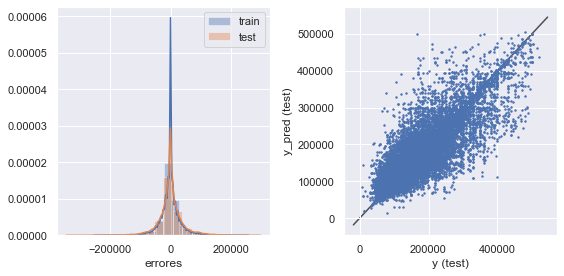

In [415]:
dist_errors(tree_model, 'Árbol de Decisión')

Con el dataset obtenido con IsolationForest se reduce el error en gran medida en comparación al proyecto 1 en el cual se obtuvo un valor aproximado de $134.000 dólares, el modelo en éste proyecto consistía en un KNN con una profundidad optimizada.

## Parte B - Modelos Avanzados

### Benchmarks
Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

#### Modelos de Regresion Lineal:  LinearRegression, Lasso y Ridge

In [416]:
#Generando atributos polinomiales
poly_features = PolynomialFeatures(include_bias=False)
X_train_new = poly_features.fit_transform(X_train)
X_test_new = poly_features.transform(X_test)

Creacion de Modelos:

In [417]:
linear_model = LinearRegression()
lasso_model = Lasso()
ridge_model = Ridge()

Modelo: Regresion Lineal
Raíz del error cuadrático medio en Train: 49728.893629494036
Raíz del error cuadrático medio en Test: 49960.59192982491


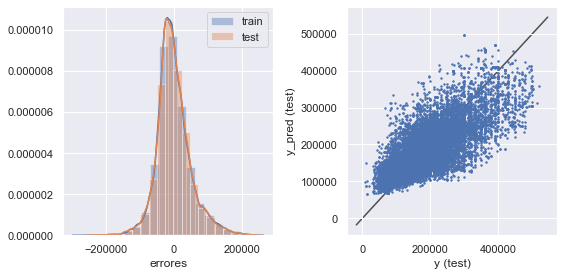

Modelo: Lasso
Raíz del error cuadrático medio en Train: 49728.89380409886
Raíz del error cuadrático medio en Test: 49960.607999874155


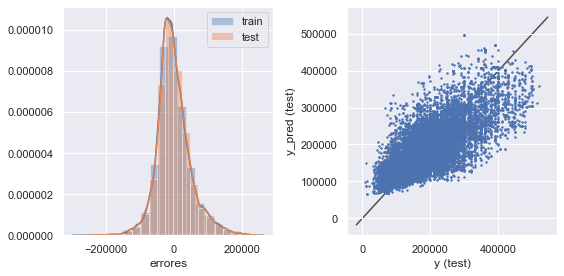

Modelo: Ridge
Raíz del error cuadrático medio en Train: 49728.893652940955
Raíz del error cuadrático medio en Test: 49960.5859155711


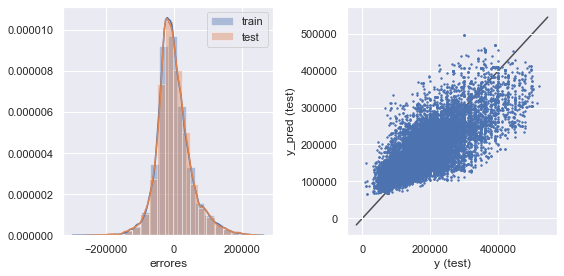

In [418]:
for title, model in zip(['Regresion Lineal', 'Lasso', 'Ridge'], [linear_model, lasso_model, ridge_model]):
    model.fit(X_train, y_train)
    dist_errors(model, title)

En los graficos obtenidos aun se puede ver que no hay una relacion entre los datos de entrada y el valor objetivo, no se consideraria un buen modelo predictivo.

* _Primera Iteracion:_ Se aplico Regularizacion con Ridge y Lasso con atributos polinomiales obteniendo valores RMSE muy altos.

* _Segunda Iteracion:_ Mismos modelos sin atributos polinomicos retornando errores mas bajos. Con los modelos LinearRegression y Ridge se obtuvo el error mas bajo con $129.212 dolares, aunque al no aplicar atributos polinomicos no seria Regularizacion.

Coeficientes:

In [419]:
for title, model in zip(['Regresion Lineal', 'Lasso', 'Ridge'], [linear_model, lasso_model, ridge_model]):
    print(title)
    print(model.coef_, '\n')

Regresion Lineal
[ 39600.10763061  20675.91168496  32345.6876046  -15171.06858366
   5991.83496823] 

Lasso
[ 39599.67603902  20673.30460914  32342.09204595 -15165.92270364
   5986.24923052] 

Ridge
[ 39599.79276898  20674.92256676  32343.55188138 -15169.64255539
   5991.2258372 ] 



Se obtuvo 6 coeficientes con valores diferentes a cero, algo esperado por no haber aplicado atributos polinomicos adicionales.

#### Modelos de Ensamble: RandomForest , Ensamble de KNN y XGBoost

__Paso 1.__ Creacion de modelos:

In [420]:
# CV RandomForest
randomForest = RandomForestRegressor(random_state=0)

# CV Ensamble KNN
bagging_knn = BaggingRegressor(KNeighborsRegressor(
    leaf_size=70, n_neighbors=20, weights='distance'), random_state=0, n_estimators=20)

# CV XGBRegressor
xgbRegressor = XGBRegressor(random_state=0)

__Paso 2.__ Validacion Cruzada:

In [421]:
n_cv = 10

# CV RandomForest
randomForest_scores = cross_val_score(randomForest, X, y, n_jobs=-1, cv=n_cv)

# CV Ensamble KNN
bagging_knn_scores = cross_val_score(bagging_knn, X, y, n_jobs=-1, cv=n_cv)

# CV XGBRegressor
xgbRegressor_scores = cross_val_score(xgbRegressor, X, y, n_jobs=-1, cv=n_cv)

In [422]:
models=['RandomForest', 'Ensamble KNN', 'XGBRegressor']
for name, model_score in zip(models,[randomForest_scores, bagging_knn_scores, xgbRegressor_scores]):
    print(f"Accuracy para {name}: %0.2f (+/- %0.2f)" % (model_score.mean(), model_score.std() * 2))

Accuracy para RandomForest: 0.77 (+/- 0.02)
Accuracy para Ensamble KNN: 0.77 (+/- 0.02)
Accuracy para XGBRegressor: 0.74 (+/- 0.02)


Se obtuvieron accuracies alrededor del 75%, por lo tanto el desempeño de los modelos no dependerá de la partición de los datos.

__Paso 3.__ Entrenamiento de modelos:

In [423]:
randomForest.fit(X_train, y_train)
bagging_knn.fit(X_train, y_train)
xgbRegressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

__Paso 4.__ Distribución de Errores:

Modelo: RandomForest
Raíz del error cuadrático medio en Train: 31456.32780293865
Raíz del error cuadrático medio en Test: 39034.43363830591


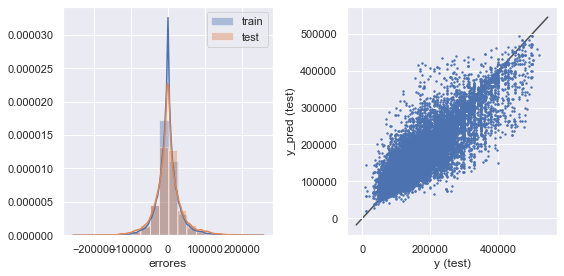

Modelo: Ensamble KNN
Raíz del error cuadrático medio en Train: 31586.3737718604
Raíz del error cuadrático medio en Test: 39084.48018409971


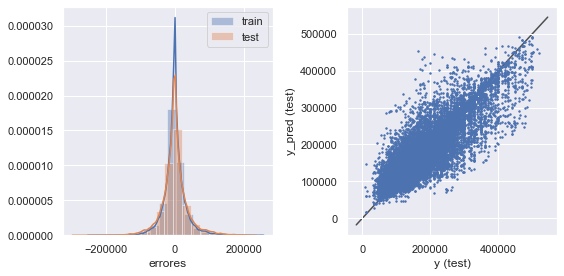

Modelo: XGBRegressor
Raíz del error cuadrático medio en Train: 37970.824486444646
Raíz del error cuadrático medio en Test: 40822.60955467623


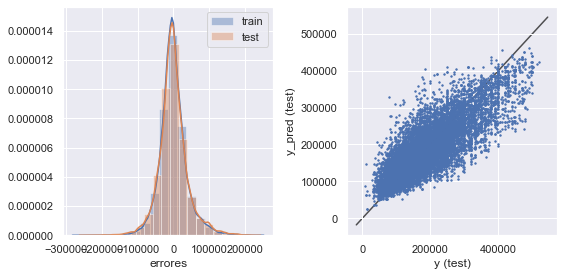

In [424]:
for model_name, model in zip(models, [randomForest, bagging_knn, xgbRegressor]):
    dist_errors(model, model_name)

De los modelos de ensamble anteriores se obtuvo menor error en Test con RandomForest

*Se responderan las siguientes preguntas usando los modelos benchmarks de esta seccion, ya que los optimizados en el paso siguiente solo varian en algunos hiperparametros.*

**Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué?** 



In [107]:
def plot_feature_importances(model):
    sns.barplot(np.arange(len(model.feature_importances_)), model.feature_importances_)

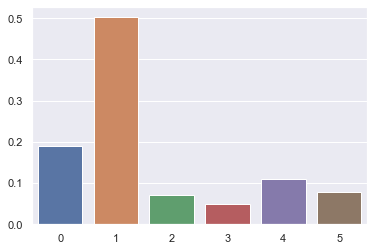

In [108]:
plot_feature_importances(randomForest)

Como se utilzo PCA para los datos de entrada, no es posible identificar el nombre de los atributos originales, sin embargo es evidente que hay una componente que aporta una importancia del 50%.

Seleccionando algunos arboles aleatorios:

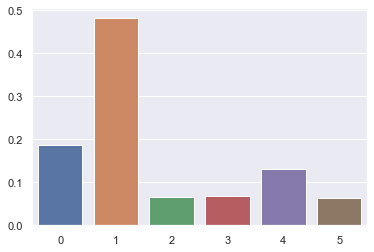

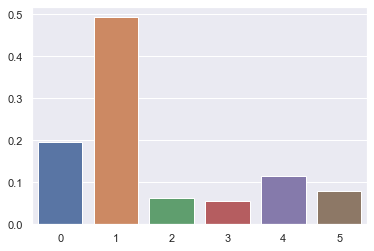

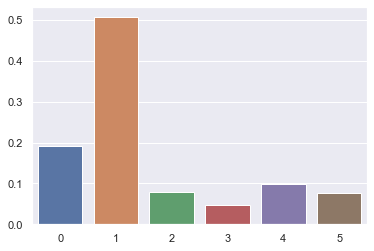

In [109]:
#Numero de arboles
n_trees=3

random_trees=np.random.choice(randomForest.estimators_, n_trees)
for model in random_trees:
    plot_feature_importances(model)
    plt.show()

Se observa que los atributos (componentes) en los modelos seleccionados aletoriamente conservan su porcentaje de importancia, algunos varian muy poco pero es algo de poca relevancia.

**Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?**

Si, aunque la expecativa era obtener un error aun mas bajo, no obstante el poder del preprocesamiento, escalado de datos, modelos mas potentes junto con la incorporacion de otras tecnicas avanzadas hizo que el resultado fuera algo mas razonable al estimar el precio de una propiedad.   
El proyecto 1 genero muchas dudas, no sabia si el tratamiento era el adecuado o faltaba optimizar algunos hiperparametros mas, en esta segunda parte descrubri que se pueden encontrar mas atributos no numericos y que al transformarlos pueden brindar mucho mas ayuda al tratar de reducir el error en cuestion.

### Optimizacion

La estrategia a utilizar consistió en ejecutar muchas iteraciones con RandomSearch, se inició un objeto de hiperparámetros con rangos amplios y se omitieron algunos de tipo float demasiado detallados y pensé que no tendrían demasiado impacto en el error. El atributo *best_params_* fué de mucha ayuda para recortar estos rangos e ir aumentando el número de iteraciones, el valor de la semilla pseudoaleatoria también tuvo implicancias en el valor del error (con random_state=0 era más bajo); aquellos hiperparámetros de tipo categórico se inicializaban directamente en el objeto del modelo cuando RandomSearch siempre los retornaba como uno de los mejores parametros. En algunas iteraciones obtenía un error más alto lo cual me obligaba a volver ampliar algunos rangos y retomar el procedimiento, hasta finalmente aplicar GridSearch con los mejores candidatos y sus rangos respectivos. 
  
Lo anterior aplicó para los modelos RandomForest y XGBoostRegressor, el ensamble de KNN requería mayores detalles al tener un modelo embebido por lo tanto implicaría mas tiempo, recursos computacionales y por supuesto, paciencia.

#### RandomForest

Objeto de Hiperparámetros:

In [425]:
random_grid = {
    'max_depth': np.arange(130, 135),
    'n_estimators': np.arange(170, 175)
}

Creación y entrenamiento del modelo:

In [426]:
gridsearch_Forest = GridSearchCV(
    RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=0),
    param_grid=random_grid, n_jobs=-1)

In [427]:
gridsearch_Forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Mejores hiperparámetros:

In [428]:
gridsearch_Forest.best_params_

{'max_depth': 130, 'n_estimators': 171}

Distribución de errores:

Modelo: GridSearch RandomForest
Raíz del error cuadrático medio en Train: 31414.670776243798
Raíz del error cuadrático medio en Test: 38928.924887989575


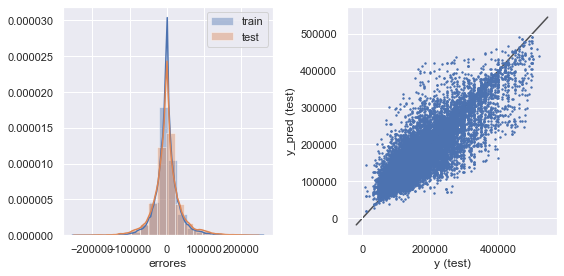

In [429]:
dist_errors(gridsearch_Forest, 'GridSearch RandomForest')

#### XGBoostRegressor

Objeto de Hiperparámetros:

In [430]:
parameters = {'nthread': [4],
              'max_depth': np.arange(13, 16),
              'n_estimators': np.arange(215, 219)
              }

Creación y entrenamiento del modelo:

In [431]:
gridsearch_xgboost = GridSearchCV(XGBRegressor(booster='gbtree',
                                             learning_rate=.02,
                                             importance_type='total_cover',
                                             colsample_bytree=0.62,
                                             random_state=0,
                                             n_jobs=-1),
                                param_grid=parameters, n_jobs=-1)

In [432]:
gridsearch_xgboost.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.62, gamma=None,
                                    gpu_id=None, importance_type='total_cover',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_para

Mejores hiperparámetros:

In [433]:
gridsearch_xgboost.best_params_

{'max_depth': 15, 'n_estimators': 218, 'nthread': 4}

Distribución de errores:

Modelo: GridSearch XGBRegressor
Raíz del error cuadrático medio en Train: 32637.581627441923
Raíz del error cuadrático medio en Test: 38870.10178010081


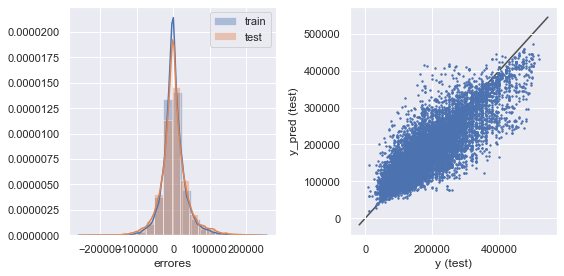

In [434]:
dist_errors(gridsearch_xgboost, 'GridSearch XGBRegressor')

La distribucion de errores en los modelos de ensamble optimizados y sin optimizar parecen corresponder a un problema de regresion, se ve que capturan mejor la relacion entre X y Y, eso explicaria el porque se obtuvo un error RMSE bajo.

### Comparacion

Los nuevos modelos vistos en el bloque 2, en especial los de ensamble, resultaron ser muy utiles en el conjunto de datos de validacion, algunos de ellos presentaban pocas diferencias en los errores incluso luedo de realizar una exhaustiva optimizacion con RandomSearch y GridSearch parecia que no se podia reducir mas. 
El modelo XGBoostRegressor, con suerte, obtuvo el menor error despues de todo con **63.728  dólares**, casi 200 dólares menos que RandomForest optimizado. Por lo tanto, se consederaría un modelo habilitado para ir a producción.

El modelo de la Parte A no se queda atrás, no es un modelo de ensamble pero tuvo una gran diferencia con el modelo del Proyecto 1; aplicando dummy a las variables l2 y property_type, y con reducción de dimensionalidad con PCA (con datos estandarizados) causó una gran reducción del error (**72.435 dólares**)

## Desafío Opcional

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?



In [123]:
standard_challenge = StandardScaler().fit_transform(
    data_challenge.drop('l3', axis=1))

In [124]:
pca_clusters = PCA(n_components=2).fit_transform(standard_challenge)

In [159]:
dbscan = DBSCAN(n_jobs=-1, eps=0.25, min_samples=3000).fit_predict(pca_clusters)

In [160]:
df_clusters=pd.DataFrame(np.c_[pca_clusters, dbscan], columns=['CP1', 'CP2', 'labels'])
mask=df_clusters==-1

In [161]:
df_clusters.labels.value_counts()

-1.0    65143
 0.0    63834
 1.0     6470
 2.0     4235
 3.0     3463
Name: labels, dtype: int64

In [164]:
data_challenge.l2_Zona_Norte.value_counts()

0.0    119448
1.0     23697
Name: l2_Zona_Norte, dtype: int64

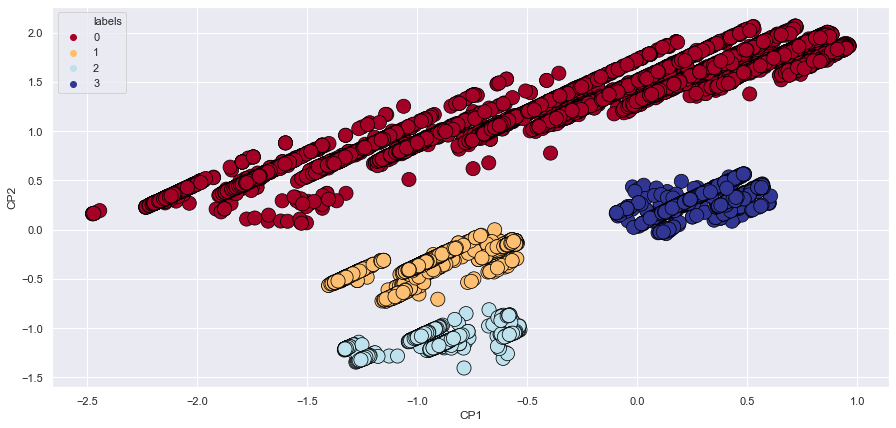

In [162]:
plt.figure(figsize=(15, 7))

sns.scatterplot(x='CP1', y='CP2', data=df_clusters[~mask], hue='labels',
                 s=200, palette='RdYlBu', ec='black', lw=0.5)